## A. Import libraries & data

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql import functions as F 

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns 
import plotly.express as px
from plotly.subplots import make_subplots

import time
from tqdm import tqdm

In [2]:
spark = SparkSession.builder \
    .appName('myPySpark') \
    .config('spark.executor.memory', '4g') \
    .config('spark.executor.cores', '4') \
    .config('spark.driver.memory', '4g') \
    .getOrCreate()

spark

Use: http://localhost:4040/jobs/

In [4]:
data_schema = StructType([
    StructField("event_time", TimestampType(), True),
    StructField("event_type", StringType(), True),
    StructField("product_id", StringType(), True),
    StructField("category_id", StringType(), True),
    StructField("category_code", StringType(), True),
    StructField("brand", StringType(), True),
    StructField("price", DoubleType(), True),
    StructField("user_id", StringType(), True),
    StructField("user_session", StringType(), True)
])


data_schema = StructType([
    StructField('event_time',TimestampeType(), True)
    ,    StructField('event_time',TimestampeType(), True)
])

In [5]:
df = spark.read.csv('2019-Nov.csv', header = True, schema = data_schema)

In [6]:
start_time = time.time()
df.cache()
end_time = time.time()
print(f"Time taken to cache the dataframe: {end_time - start_time:.2f} seconds")
print(f"Total number of records: {df.count()}")

Time taken to cache the dataframe: 0.83 seconds
Total number of records: 67501979


👆👆👆 such a huge dataset

In [7]:
df.show()

+-------------------+----------+----------+-------------------+--------------------+--------+------+---------+--------------------+
|         event_time|event_type|product_id|        category_id|       category_code|   brand| price|  user_id|        user_session|
+-------------------+----------+----------+-------------------+--------------------+--------+------+---------+--------------------+
|2019-11-01 07:00:00|      view|   1003461|2053013555631882655|electronics.smart...|  xiaomi|489.07|520088904|4d3b30da-a5e4-49d...|
|2019-11-01 07:00:00|      view|   5000088|2053013566100866035|appliances.sewing...|  janome|293.65|530496790|8e5f4f83-366c-4f7...|
|2019-11-01 07:00:01|      view|  17302664|2053013553853497655|                NULL|   creed| 28.31|561587266|755422e7-9040-477...|
|2019-11-01 07:00:01|      view|   3601530|2053013563810775923|appliances.kitche...|      lg|712.87|518085591|3bfb58cd-7892-48c...|
|2019-11-01 07:00:01|      view|   1004775|2053013555631882655|electronics.s

In [8]:
df.printSchema()

root
 |-- event_time: timestamp (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- category_id: string (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: double (nullable = true)
 |-- user_id: string (nullable = true)
 |-- user_session: string (nullable = true)



## B. Data Normalization

### I. Principles

Based on the dataset, I would like to separate the dataset into different Normal Forms
#### 1. First Normal Form (1NF):  
<b> Definition: </b> A table is in 1NF if it contains only atomic (indivisible) values, and each column contains values of a single type.

Table: Events

| event_time          | event_type        | product_id  | category_id  | category_code         | brand    | price   | user_id   | user_session                         |
|---------------------|-------------------|-------------|--------------|-----------------------|----------|---------|-----------|--------------------------------------|
| 2019-11-01 00:00:00 | view              | 1003461     | 2053013555   | electronics.smartphone | xiaomi   | 489.07  | 520088904 | 4d3b30da-a5e4-49df-b1a8-ba5943f1dd33 |
| 2019-11-01 00:00:00 | view              | 5000088     | 2053013566   | appliances.sewing_machine | janome  | 293.65  | 530496790 | 8e5f4f83-366c-4f70-860e-ca7417414283 |
...


#### 2. Second Normal Form (2NF):
<b>Definition: </b> A table is in 2NF if it is in 1NF and all non-key attributes are fully functional dependent on the primary key.

To achieve 2NF, I need to ensure that each non-key attribute is fully dependent on the primary key. For this dataset, I can break down the Events table into smaller tables to remove partial dependencies.

1/ Table: Events
| event_time          | event_type | product_id  | user_id   | user_session                         |
|---------------------|------------|-------------|-----------|--------------------------------------|
| 2019-11-01 00:00:00 | view       | 1003461     | 520088904 | 4d3b30da-a5e4-49df-b1a8-ba5943f1dd33 |
| 2019-11-01 00:00:00 | view       | 5000088     | 530496790 | 8e5f4f83-366c-4f70-860e-ca7417414283 |
...


2/ Table: Products
| product_id  | category_id  | category_code         | brand    | price   |
|-------------|--------------|-----------------------|----------|---------|
| 1003461     | 2053013555   | electronics.smartphone | xiaomi   | 489.07  |
| 5000088     | 2053013566   | appliances.sewing_machine | janome  | 293.65  |
...

3/ Table: Categories
| category_id  | category_code         |
|--------------|-----------------------|
| 2053013555   | electronics.smartphone |
| 2053013566   | appliances.sewing_machine |
...


#### 3. Third Normal Form (3NF)
<b>Definition:</b> A table is in 3NF if it is in 2NF and all the attributes are functionally dependent only on the primary key.

To achieve 3NF, I remove transitive dependencies. For example, the category_code can be moved to a separate Categories table as shown above. I already separated Products and Categories in 2NF, so I might only need to check if further decomposition is necessary.

1/ Table: Events
| event_time          | event_type | product_id  | user_session                         |
|---------------------|------------|-------------|--------------------------------------|
| 2019-11-01 00:00:00 | view       | 1003461     | 4d3b30da-a5e4-49df-b1a8-ba5943f1dd33 |
| 2019-11-01 00:00:00 | view       | 5000088     | 8e5f4f83-366c-4f70-860e-ca7417414283 |
...

2/ Table: Products
| product_id  | category_id  | brand    | price   |
|-------------|--------------|----------|---------|
| 1003461     | 2053013555   | xiaomi   | 489.07  |
| 5000088     | 2053013566   | janome   | 293.65  |
...


3/ Table: Categories
| category_id  | category_code         |
|--------------|-----------------------|
| 2053013555   | electronics.smartphone |
| 2053013566   | appliances.sewing_machine |
...


4/ Table: Users
| user_id   | user_session                         |
|-----------|--------------------------------------|
| 520088904 | 4d3b30da-a5e4-49df-b1a8-ba5943f1dd33 |
| 530496790 | 8e5f4f83-366c-4f70-860e-ca7417414283 |
...


### II. Normalization

In [9]:
events = df.select(['event_time','event_type','product_id' ,'user_session']).dropDuplicates()
products = df.select(['product_id','category_id' ,'brand' ,'price']).dropDuplicates()
categories = df.select(['category_id', 'category_code']).dropDuplicates()
users = df.select(['user_id','user_session']).dropDuplicates()

In [10]:
#Create a table for SQL statement
products.createOrReplaceTempView("products_view")

In [11]:
spark.sql("""
SELECT 
    product_id
    ,COUNT(DISTINCT price) as distinct_price_value
FROM products_view
GROUP BY product_id
HAVING COUNT(DISTINCT price) > 1
""").show()

+----------+--------------------+
|product_id|distinct_price_value|
+----------+--------------------+
|   3200376|                   7|
|   4200507|                   3|
|  12701113|                   2|
|   1005171|                  80|
|  11700020|                   2|
|   2602206|                   5|
|   8500452|                  16|
|   4500623|                   6|
|  14000352|                   4|
|  18001540|                   2|
|   5200095|                   5|
|  38400008|                   3|
|  11900389|                   2|
|   5100417|                  12|
|  27600165|                   2|
|   4802182|                   4|
|  11700175|                   3|
|  34200102|                   3|
|  14701738|                   3|
|   3600912|                   3|
+----------+--------------------+
only showing top 20 rows



In [12]:
#Remove table's cache
spark.catalog.uncacheTable('products_view')

The reason for some product_ids have many price values is fluctuation of price during the timespan. The company had to adjust the price to be more competitive with the competitors.   
So I would like to normalize the products table again. And the price might be unique in a single user_session.

In [13]:
products = df.select(['product_id','category_id' ,'brand' ,'price', 'user_session']).dropDuplicates()

In [14]:
events.show(3)

+-------------------+----------+----------+--------------------+
|         event_time|event_type|product_id|        user_session|
+-------------------+----------+----------+--------------------+
|2019-11-01 07:00:42|      view|  12720155|f7e8ffaa-5103-47f...|
|2019-11-01 07:00:55|      view|   1307519|e1e8125d-da26-49e...|
|2019-11-01 07:02:56|      view|   1801881|4d76d6d3-fff5-488...|
+-------------------+----------+----------+--------------------+
only showing top 3 rows



In [15]:
products.show(3)

+----------+-------------------+-------+------+--------------------+
|product_id|        category_id|  brand| price|        user_session|
+----------+-------------------+-------+------+--------------------+
|   1003317|2053013555631882655|  apple|928.18|d2d3d2c6-631d-489...|
|  26400273|2053013563651392361|lucente|224.46|3dc250b7-9bd1-4c9...|
|   1005211|2053013555631882655|samsung|193.26|3aa2b23a-a633-441...|
+----------+-------------------+-------+------+--------------------+
only showing top 3 rows



In [16]:
categories.show(3)

+-------------------+------------------+
|        category_id|     category_code|
+-------------------+------------------+
|2097815753423061045|    apparel.tshirt|
|2053013566277026813|      apparel.belt|
|2053013565069067197|apparel.shoes.keds|
+-------------------+------------------+
only showing top 3 rows



In [17]:
users.show(3)

+---------+--------------------+
|  user_id|        user_session|
+---------+--------------------+
|520772685|816a59f3-f5ae-4cc...|
|513200477|742aba02-727b-4d1...|
|553802615|e09684bb-0c95-4f6...|
+---------+--------------------+
only showing top 3 rows



### III. Save to MSSQLSV

In [30]:
#set variable to be used to connect the database
database = 'tu_local_db'
user = 'tulinh'
password  = '******'
service = 'localhost'
port = '1433'
jdbc_url = f'jdbc:sqlserver://{service}:{port};databaseName={database};encrypt=true;trustServerCertificate=true'
jdbc_driver = 'com.microsoft.sqlserver.jdbc.SQLServerDriver'

#write the dataframe into a sql table
users.write.mode('overwrite') \
    .format('jdbc') \
    .option('url', jdbc_url) \
    .option('dbtable', 'dbo.users') \
    .option('user', user) \
    .option('password', password) \
    .option('driver', jdbc_driver) \
    .save()

categories.write.mode('overwrite') \
    .format('jdbc') \
    .option('url', jdbc_url) \
    .option('dbtable', 'dbo.categories') \
    .option('user', user) \
    .option('password', password) \
    .option('driver', jdbc_driver) \
    .save()

products.write.mode('overwrite') \
    .format('jdbc') \
    .option('url', jdbc_url) \
    .option('dbtable', 'dbo.products') \
    .option('user', user) \
    .option('password', password) \
    .option('driver', jdbc_driver) \
    .save()

events.write.mode('overwrite') \
    .format('jdbc') \
    .option('url', jdbc_url) \
    .option('dbtable', 'dbo.events') \
    .option('user', user) \
    .option('password', password) \
    .option('driver', jdbc_driver) \
    .save()

The output as below 👌

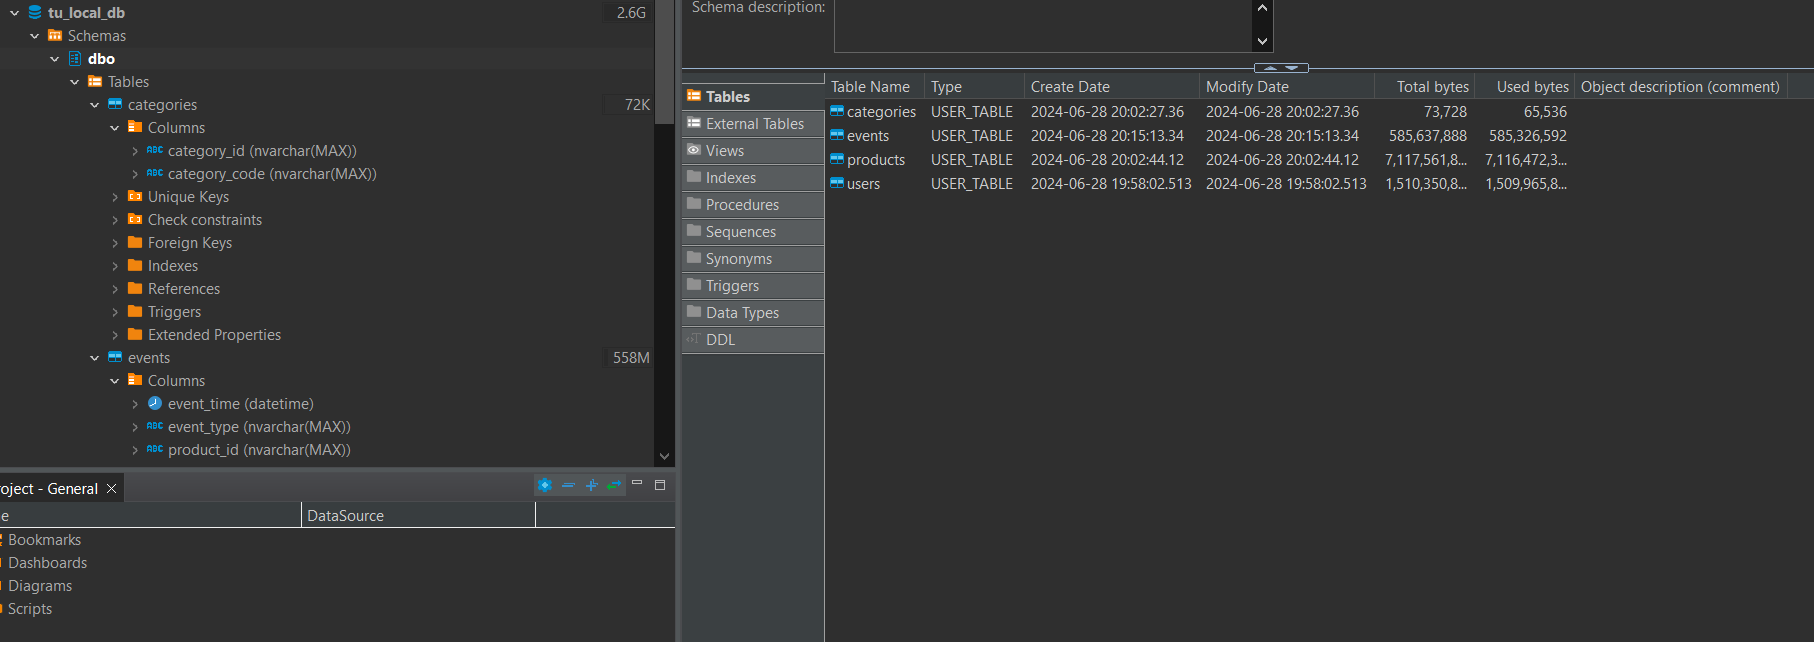

In [2]:
from IPython.display import Image
Image(filename='sample-output.png')

In [ ]:
# spark.close()

## C. Further Analysis

In [ ]:
df = df.withColumn('event_date', F.to_date(df['event_time']))

In [ ]:
df.show(3)

+-------------------+----------+----------+-------------------+--------------------+------+------+---------+--------------------+----------+
|         event_time|event_type|product_id|        category_id|       category_code| brand| price|  user_id|        user_session|event_date|
+-------------------+----------+----------+-------------------+--------------------+------+------+---------+--------------------+----------+
|2019-11-01 07:00:00|      view|   1003461|2053013555631882655|electronics.smart...|xiaomi|489.07|520088904|4d3b30da-a5e4-49d...|2019-11-01|
|2019-11-01 07:00:00|      view|   5000088|2053013566100866035|appliances.sewing...|janome|293.65|530496790|8e5f4f83-366c-4f7...|2019-11-01|
|2019-11-01 07:00:01|      view|  17302664|2053013553853497655|                NULL| creed| 28.31|561587266|755422e7-9040-477...|2019-11-01|
+-------------------+----------+----------+-------------------+--------------------+------+------+---------+--------------------+----------+
only showing 

In [ ]:
df.select(['event_type']).dropDuplicates().show(3)

+----------+
|event_type|
+----------+
|  purchase|
|      view|
|      cart|
+----------+



In [ ]:
# Calculate the number of events per day
events_per_day = df.groupBy(['event_date','event_type']).agg(
    F.count('user_session').alias('session_count')
    ,F.count('event_type').alias('event_count')
).orderBy(F.desc('event_count'))

# count().orderBy('event_date')
events_per_day.show(5)

+----------+----------+-------------+-----------+
|event_date|event_type|session_count|event_count|
+----------+----------+-------------+-----------+
|2019-11-17|      view|      6347489|    6347489|
|2019-11-16|      view|      6102759|    6102759|
|2019-11-15|      view|      5536508|    5536508|
|2019-11-14|      view|      2198544|    2198544|
|2019-11-18|      view|      2192070|    2192070|
+----------+----------+-------------+-----------+
only showing top 5 rows



In [ ]:
# Calculate the total revenue per day
revenue_per_day = df.filter(df['event_type'] == 'purchase').groupBy('event_date').agg(F.sum('price').alias('total_revenue')).orderBy('event_date')
revenue_per_day.show(5)

+----------+------------------+
|event_date|     total_revenue|
+----------+------------------+
|2019-11-01| 5986270.709999872|
|2019-11-02|6421346.3999999575|
|2019-11-03| 6374722.729999999|
|2019-11-04| 8124310.640000036|
|2019-11-05| 7360248.350000051|
+----------+------------------+
only showing top 5 rows



In [ ]:
#Cache for faster reusability
events_per_day.cache()
revenue_per_day.cache()

DataFrame[event_date: date, total_revenue: double]

In [ ]:
#Cast as Pandas Dataframe
events_per_day_pd = events_per_day.toPandas()
revenue_per_day_pd = revenue_per_day.toPandas()

In [ ]:
#Remove cache
events_per_day.unpersist()
revenue_per_day.unpersist()

DataFrame[event_date: date, total_revenue: double]

In [ ]:
events_per_day_pd['event_date'] = events_per_day_pd['event_date'].astype('datetime64[ns]')
revenue_per_day_pd['event_date'] = revenue_per_day_pd['event_date'].astype('datetime64[ns]')

In [ ]:
events_per_day_pd.head()

,event_date,event_type,session_count,event_count
0,2019-11-17,view,6347489,6347489
1,2019-11-16,view,6102759,6102759
2,2019-11-15,view,5536508,5536508
3,2019-11-14,view,2198544,2198544
4,2019-11-18,view,2192070,2192070


### I. Sales Trend

C:\Users\TuNguyen\AppData\Local\Temp\ipykernel_968\742392260.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


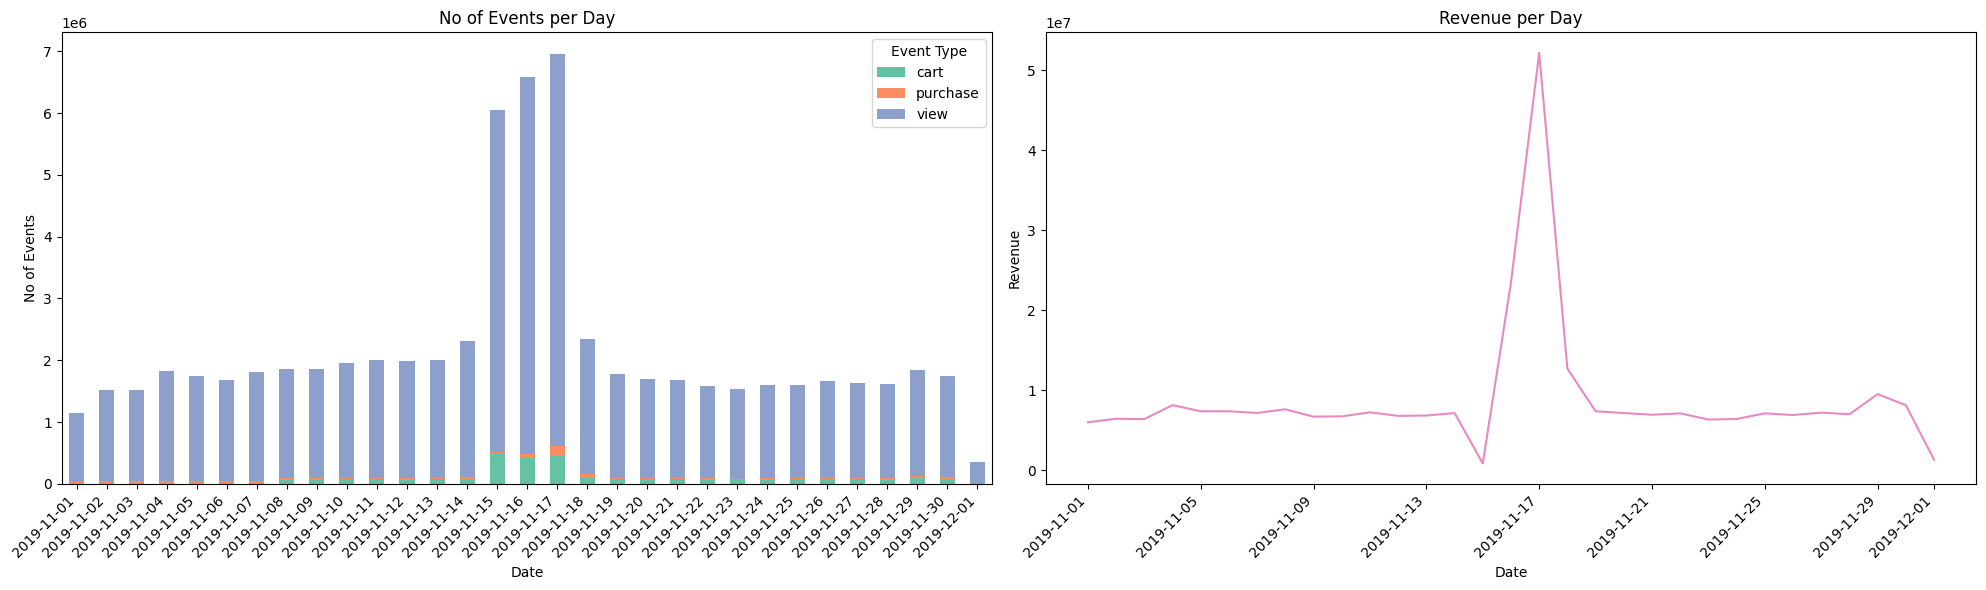

In [ ]:
events_per_day_pd['event_date'] = events_per_day_pd['event_date'].astype('str')
events_pivot = events_per_day_pd.pivot(index='event_date'
                                       , columns='event_type'
                                       , values='event_count').fillna(0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

events_pivot.plot(kind='bar', stacked=True, color=['#66c2a5', '#fc8d62', '#8da0cb'], ax = ax1)
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# ax1.xaxis.set_major_locator(mdates.DayLocator())
ax1.set_xlabel('Date')
ax1.set_ylabel('No of Events')
ax1.set_title('No of Events per Day')
ax1.legend(title='Event Type')
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

sns.lineplot(data=revenue_per_day_pd
             , x='event_date'
             , y='total_revenue'
             , color = '#e78ac3'
             , ax = ax2)

ax2.set_xlabel('Date')
ax2.set_ylabel('Revenue')
ax2.set_title('Revenue per Day')
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

fig.tight_layout()
fig.show()

The company registered the highest revenue in The company registered its highest revenue on November 17th, exceeding $50 million. This peak can be attributed to a significant increase in customer journey activities, such as views and cart additions, which surged approximately 2-3 days prior to this date.

Analyzing the data, it's evident that November 17, 2019, marked a revenue peak for the company. This spike in sales is closely linked to elevated customer engagement metrics, with noticeable upticks in website views and items added to carts occurring a few days beforehand. These heightened pre-purchase activities likely fueled the record-breaking revenue on November 17th.

### II. Cohort Analysis

In [ ]:
purchase_df = df.filter(df['event_type'] == 'purchase')

In [ ]:
purchase_pdf = purchase_df.toPandas()
purchase_pdf.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,event_date
0,2019-11-01 07:00:41,purchase,13200605,2053013557192163841,furniture.bedroom.bed,None,566.30,559368633,d6034fa2-41fb-4ac0-9051-55ea9fc9147a,2019-11-01
1,2019-11-01 07:01:04,purchase,1005161,2053013555631882655,electronics.smartphone,xiaomi,211.92,513351129,e6b7ce9b-1938-4e20-976c-8b4163aea11d,2019-11-01
2,2019-11-01 07:04:51,purchase,1004856,2053013555631882655,electronics.smartphone,samsung,128.42,562958505,0f039697-fedc-40fa-8830-39c1a024351d,2019-11-01
3,2019-11-01 07:05:34,purchase,26401669,2053013563651392361,None,lucente,109.66,541854711,c41c44d5-ef9b-41b9-9cd6-8d96dda6e927,2019-11-01
4,2019-11-01 07:06:33,purchase,1801881,2053013554415534427,electronics.video.tv,samsung,488.80,557746614,4d76d6d3-fff5-4880-8327-e9e57b618e0e,2019-11-01


In [ ]:
purchase_pdf_min = purchase_pdf.groupby(by = 'user_id', as_index = False).agg(first_event_date = ('event_date','min'))

In [ ]:
purchase_pdf = purchase_pdf.merge(purchase_pdf_min, on = 'user_id', how = 'inner')

In [ ]:
purchase_pdf['first_event_date'] = purchase_pdf['first_event_date'].astype('datetime64[ns]')
purchase_pdf['start_of_week'] = purchase_pdf['first_event_date'] - pd.to_timedelta(purchase_pdf['first_event_date'].dt.dayofweek, unit='d')
purchase_pdf['end_of_week'] = purchase_pdf['start_of_week'] - pd.to_timedelta(6, unit='d')
purchase_pdf['week_number'] = purchase_pdf['first_event_date'].dt.isocalendar().week
purchase_pdf['week_text'] = 'W' + purchase_pdf['week_number'].astype('str')

In [ ]:
purchase_pdf['cohort_index_week'] = purchase_pdf['week_text'] + ' (' \
                                + purchase_pdf['start_of_week'].astype('str') \
                                + ' ➜ ' + purchase_pdf['end_of_week'].astype('str') + ')'
purchase_pdf.head()

,user_id,event_time,event_type,product_id,category_id,category_code,brand,price,user_session,event_date,first_event_date,start_of_week,week_number,end_of_week,week_text,cohort_index_week,week_after
0,559368633,2019-11-01 07:00:41,purchase,13200605,2053013557192163841,furniture.bedroom.bed,None,566.30,d6034fa2-41fb-4ac0-9051-55ea9fc9147a,2019-11-01,2019-11-01,2019-10-28,44,2019-10-22,W44,W44 (2019-10-28 ➜ 2019-10-22),0
1,513351129,2019-11-01 07:01:04,purchase,1005161,2053013555631882655,electronics.smartphone,xiaomi,211.92,e6b7ce9b-1938-4e20-976c-8b4163aea11d,2019-11-01,2019-11-01,2019-10-28,44,2019-10-22,W44,W44 (2019-10-28 ➜ 2019-10-22),0
2,562958505,2019-11-01 07:04:51,purchase,1004856,2053013555631882655,electronics.smartphone,samsung,128.42,0f039697-fedc-40fa-8830-39c1a024351d,2019-11-01,2019-11-01,2019-10-28,44,2019-10-22,W44,W44 (2019-10-28 ➜ 2019-10-22),0
3,541854711,2019-11-01 07:05:34,purchase,26401669,2053013563651392361,None,lucente,109.66,c41c44d5-ef9b-41b9-9cd6-8d96dda6e927,2019-11-01,2019-11-01,2019-10-28,44,2019-10-22,W44,W44 (2019-10-28 ➜ 2019-10-22),0
4,557746614,2019-11-01 07:06:33,purchase,1801881,2053013554415534427,electronics.video.tv,samsung,488.80,4d76d6d3-fff5-4880-8327-e9e57b618e0e,2019-11-01,2019-11-01,2019-10-28,44,2019-10-22,W44,W44 (2019-10-28 ➜ 2019-10-22),0


In [ ]:
purchase_pdf['week_after'] = ((purchase_pdf['event_date'].astype('datetime64[ns]') - purchase_pdf['first_event_date'].astype('datetime64[ns]')).dt.days // 7).astype(int)
purchase_pdf.head()

,user_id,event_time,event_type,product_id,category_id,category_code,brand,price,user_session,event_date,first_event_date,start_of_week,week_number,end_of_week,week_text,cohort_index_week,week_after
0,559368633,2019-11-01 07:00:41,purchase,13200605,2053013557192163841,furniture.bedroom.bed,None,566.30,d6034fa2-41fb-4ac0-9051-55ea9fc9147a,2019-11-01,2019-11-01,2019-10-28,44,2019-10-22,W44,W44 (2019-10-28 ➜ 2019-10-22),0
1,513351129,2019-11-01 07:01:04,purchase,1005161,2053013555631882655,electronics.smartphone,xiaomi,211.92,e6b7ce9b-1938-4e20-976c-8b4163aea11d,2019-11-01,2019-11-01,2019-10-28,44,2019-10-22,W44,W44 (2019-10-28 ➜ 2019-10-22),0
2,562958505,2019-11-01 07:04:51,purchase,1004856,2053013555631882655,electronics.smartphone,samsung,128.42,0f039697-fedc-40fa-8830-39c1a024351d,2019-11-01,2019-11-01,2019-10-28,44,2019-10-22,W44,W44 (2019-10-28 ➜ 2019-10-22),0
3,541854711,2019-11-01 07:05:34,purchase,26401669,2053013563651392361,None,lucente,109.66,c41c44d5-ef9b-41b9-9cd6-8d96dda6e927,2019-11-01,2019-11-01,2019-10-28,44,2019-10-22,W44,W44 (2019-10-28 ➜ 2019-10-22),0
4,557746614,2019-11-01 07:06:33,purchase,1801881,2053013554415534427,electronics.video.tv,samsung,488.80,4d76d6d3-fff5-4880-8327-e9e57b618e0e,2019-11-01,2019-11-01,2019-10-28,44,2019-10-22,W44,W44 (2019-10-28 ➜ 2019-10-22),0


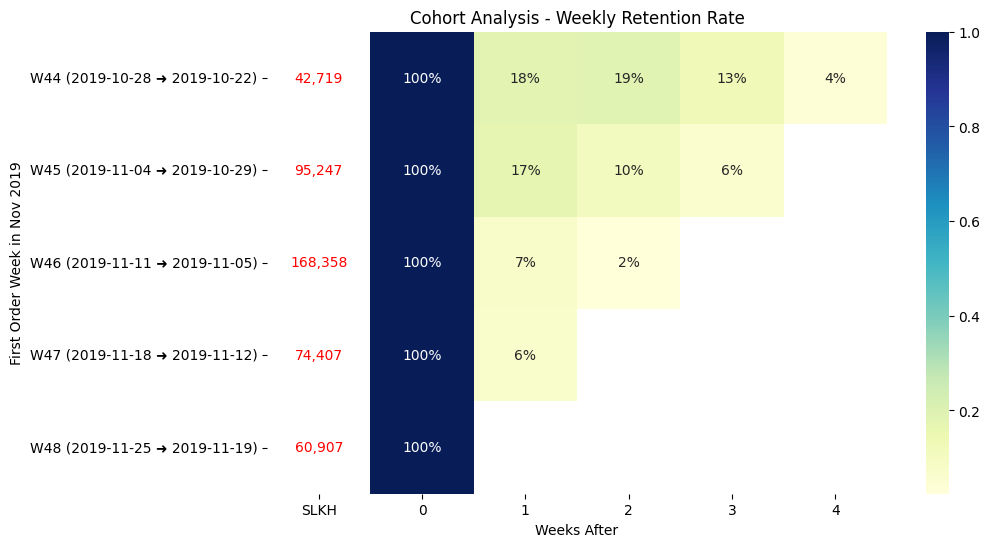

In [ ]:
purchase_pdf_pivot = purchase_pdf.pivot_table(index = 'cohort_index_week'
                                            , columns = 'week_after'
                                            , values = 'user_id'
                                            , aggfunc = 'nunique')

df_cohort_new = purchase_pdf_pivot
empty_column = pd.Series([0] * len(df_cohort_new), name='SLKH')
df_cohort_new.insert(loc=0, column='SLKH', value=empty_column)

cohort_size_monthly_new = df_cohort_new.iloc[:, 1]
retention_matrix_monthly_new = df_cohort_new.divide(cohort_size_monthly_new, axis=0)

plt.figure(figsize= (10,6))
sns.heatmap(data = retention_matrix_monthly_new
            ,annot=True
            ,cmap='YlGnBu'
            ,fmt = '.0%')

for i in range(len(purchase_pdf_pivot)):
    plt.text(0.5, i + 0.5, '{:,.0f}'.format(purchase_pdf_pivot.iloc[i, 1])
            , ha='center'
            , va='center'
            , color = 'red')
    
plt.xlabel('Weeks After')
plt.ylabel('First Order Week in Nov 2019')
plt.title('Cohort Analysis - Weekly Retention Rate')

plt.show()

> RETENTION OVER WEEKS:

1. <b> Users Acquisition </b>: It can be clearly seen that W46 acquired the highest number of new customers in Nov 2019. With 168k new users purchased in W46, this week even quadruple W44, but the engagement rate is significantly lower. I suggest optimization or adjustments may be needed in the customer onboarding or retention strategies to improve engagement and conversion rates. 

2. <b> Engagement Decline </b>: There is a noticeable decline in engagement as we move further away from the initial week of acquisition (cohort week). For example, in cohort W44, the engagement rate drops from 19% in week 2 to 4% in week 4. This suggests that customers from these cohorts are gradually becoming less active or making fewer purchases over time so we have to wake them up before the hibernation.

### III. Market Preferences

In [ ]:
def format_large_numbers(value):
    if value >= 1e9:
        return f'{value/1e9:.1f}B'
    elif value >= 1e6:
        return f'{value/1e6:.1f}M'
    elif value >= 1e3:
        return f'{value/1e3:.1f}K'
    else:
        return str(value)

In [ ]:
purchase_by_brand_sorted_revenue = purchase_df.groupBy('brand').agg(
    F.sum('price').alias('total_revenue')
    ,F.count('event_type').alias('purchase_count')
).orderBy(F.desc('total_revenue')).toPandas()

purchase_by_brand_sorted_count = purchase_df.groupBy('brand').agg(
    F.sum('price').alias('total_revenue')
    ,F.count('event_type').alias('purchase_count')
).orderBy(F.desc('purchase_count')).toPandas()

purchase_by_brand_sorted_revenue['total_revenue'] = purchase_by_brand_sorted_revenue['total_revenue'].astype('int64')
purchase_by_brand_sorted_count['purchase_count'] = purchase_by_brand_sorted_count['purchase_count'].astype('int64')

C:\Users\TuNguyen\AppData\Local\Temp\ipykernel_968\793302559.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=purchase_by_brand_sorted_revenue.head(10)
C:\Users\TuNguyen\AppData\Local\Temp\ipykernel_968\793302559.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=purchase_by_brand_sorted_count.head(10)


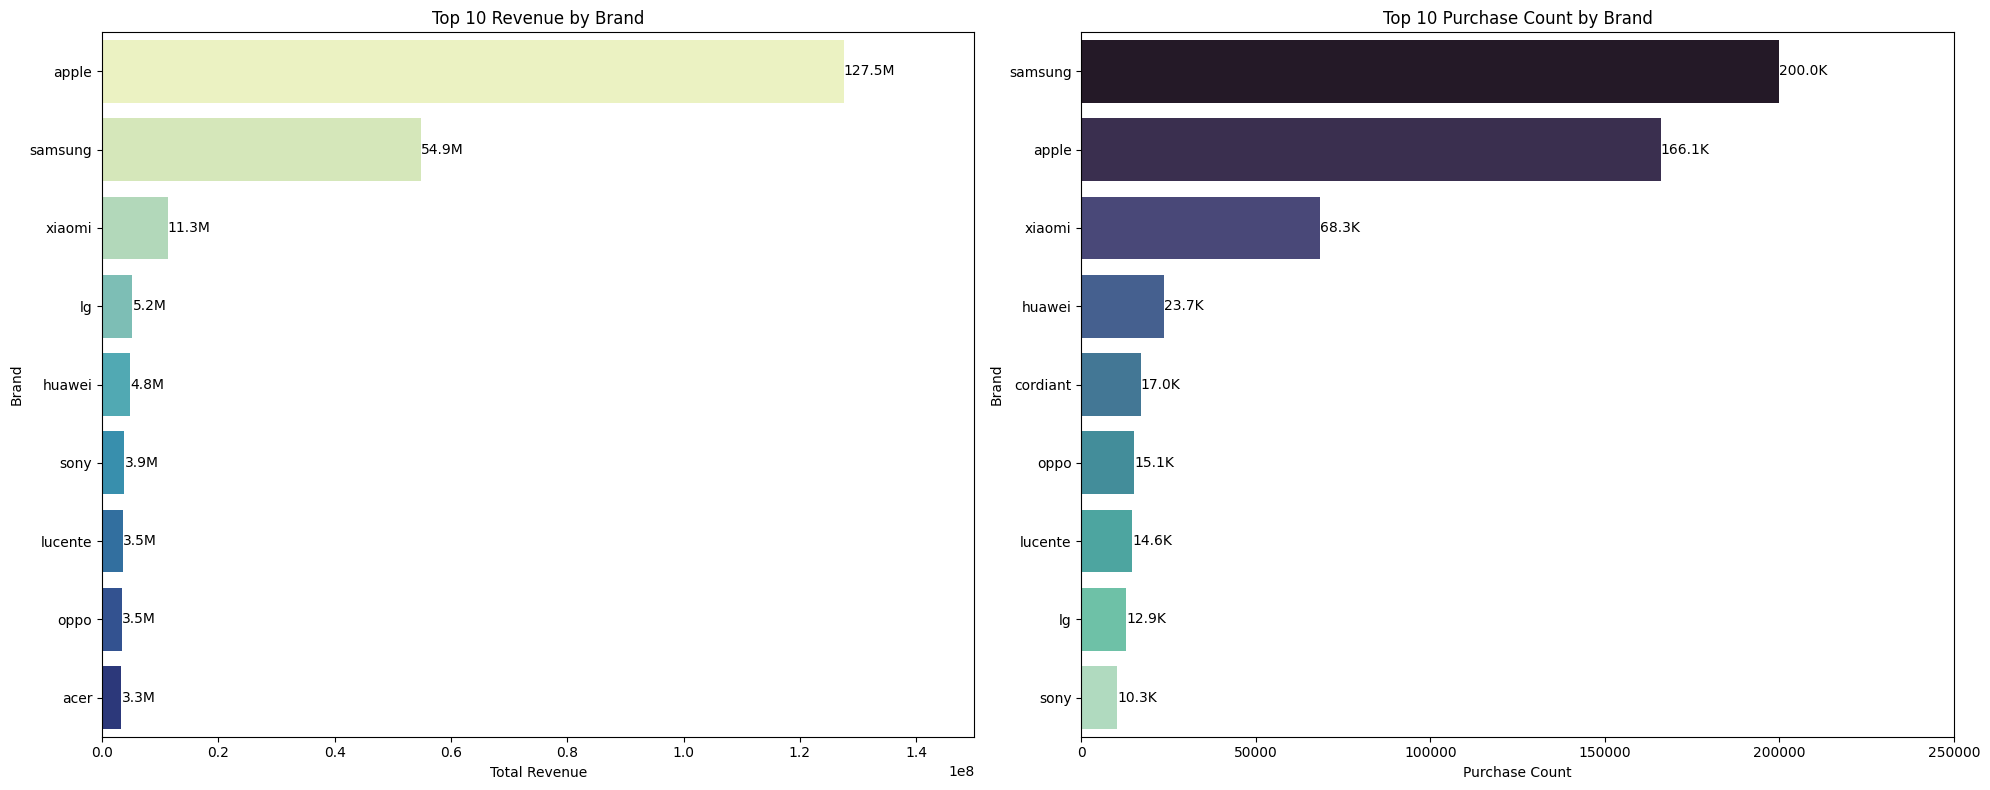

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot the bar chart for TOP 10 total revenue
sns.barplot(data=purchase_by_brand_sorted_revenue.head(10)
            , y='brand'
            , x='total_revenue'
            , palette = 'YlGnBu'
            , ax=ax1)
ax1.set_title('Top 10 Revenue by Brand')
ax1.set_xlabel('Total Revenue')
ax1.set_ylabel('Brand')
ax1.set_xlim(0,150000000)
for i in ax1.containers:
    ax1.bar_label(i, labels=[format_large_numbers(x) for x in i.datavalues])

# Plot the bar chart for TOP 10 purchase count
sns.barplot(data=purchase_by_brand_sorted_count.head(10)
            , y='brand'
            , x='purchase_count'
            , palette = 'mako'
            , ax=ax2)
ax2.set_title('Top 10 Purchase Count by Brand')
ax2.set_xlabel('Purchase Count')
ax2.set_ylabel('Brand')
ax2.set_xlim(0,250000)
for j in ax2.containers:
    ax2.bar_label(j, labels=[format_large_numbers(x) for x in j.datavalues])

plt.tight_layout()

plt.show()

> MARKET INSIGHTS:  

<b> 1. Apple Leads in Revenue </b>: Apple dominates the revenue chart with $127.5M, more than double Samsung's $54.9M, indicating high-value products contributing to significant revenue despite a lower purchase count compared to Samsung.

<b> 2. Samsung Leads in Purchase Count</b>: Samsung tops the purchase count with 200.0K purchases, surpassing Apple's 166.1K. This suggests Samsung products have a higher volume of sales, possibly due to a wider range of mid to low-priced products.

<b> 3. Revenue vs Purchase Count</b>: Despite Apple having a lower purchase count compared to Samsung, its revenue is significantly higher. This highlights that Apple's products are generally priced higher than Samsung's.

<b> 4. Xiaomi's Strong Presence</b>: Xiaomi ranks third in both revenue ($11.3M) and purchase count (68.3K), showing its balanced performance in terms of both sales volume and revenue generation.

<b> 5. Other Brands</b>: LG, Huawei, Sony, and others show a noticeable presence, but with significantly lower figures in both revenue and purchase count compared to Apple and Samsung. Huawei has a relatively higher purchase count compared to its revenue, indicating lower-priced products.

<b> 6. Market Segmentation</b>: The difference in rankings between revenue and purchase count among brands like LG, Sony, and Huawei indicates varied market strategies focusing on either high volume (more affordable products) or high value (premium products).

### IV. Customer Segmentation

In [ ]:
# purchase_pdf.to_csv('purchase_pdf.csv', index = False)

In [ ]:
purchase_pdf = pd.read_csv('purchase_pdf.csv')
purchase_pdf.head()

,user_id,event_time,event_type,product_id,category_id,category_code,brand,price,user_session,event_date,first_event_date,start_of_week,week_number,end_of_week,week_text,cohort_index_week,week_after
0,559368633,2019-11-01 07:00:41,purchase,13200605,2053013557192163841,furniture.bedroom.bed,NaN,566.30,d6034fa2-41fb-4ac0-9051-55ea9fc9147a,2019-11-01,2019-11-01,2019-10-28,44,2019-10-22,W44,W44 (2019-10-28 ➜ 2019-10-22),0
1,513351129,2019-11-01 07:01:04,purchase,1005161,2053013555631882655,electronics.smartphone,xiaomi,211.92,e6b7ce9b-1938-4e20-976c-8b4163aea11d,2019-11-01,2019-11-01,2019-10-28,44,2019-10-22,W44,W44 (2019-10-28 ➜ 2019-10-22),0
2,562958505,2019-11-01 07:04:51,purchase,1004856,2053013555631882655,electronics.smartphone,samsung,128.42,0f039697-fedc-40fa-8830-39c1a024351d,2019-11-01,2019-11-01,2019-10-28,44,2019-10-22,W44,W44 (2019-10-28 ➜ 2019-10-22),0
3,541854711,2019-11-01 07:05:34,purchase,26401669,2053013563651392361,NaN,lucente,109.66,c41c44d5-ef9b-41b9-9cd6-8d96dda6e927,2019-11-01,2019-11-01,2019-10-28,44,2019-10-22,W44,W44 (2019-10-28 ➜ 2019-10-22),0
4,557746614,2019-11-01 07:06:33,purchase,1801881,2053013554415534427,electronics.video.tv,samsung,488.80,4d76d6d3-fff5-4880-8327-e9e57b618e0e,2019-11-01,2019-11-01,2019-10-28,44,2019-10-22,W44,W44 (2019-10-28 ➜ 2019-10-22),0


> Some of the features being used while clustering: 

1. Recency: The time since the last purchase made by each user. This could be calculated by subtracting the latest "event_time" for each user from the current date.

2. Frequency: The total number of purchases made by each user within a certain time period.

3. Monetary Value: The total amount spent by each user over all their purchases.

In [ ]:
purchase_pdf['event_date'] = purchase_pdf['event_date'].astype('datetime64[ns]')

In [ ]:
# Calculate Recency, Frequency, Monetary
current_date = purchase_pdf['event_time'].astype('datetime64[ns]').max()
customer_features = purchase_pdf.groupby(by = 'user_id', as_index = False).agg(last_date = ('event_date', 'max')
                                                            , frequency = ('event_type', 'count')
                                                            , monetary = ('price', 'sum'))
customer_features['recency'] = (current_date - customer_features['last_date']).dt.days
customer_features.drop(columns = 'last_date', inplace = True)

Text(0.5, 1.0, 'Correlation Heatmap')

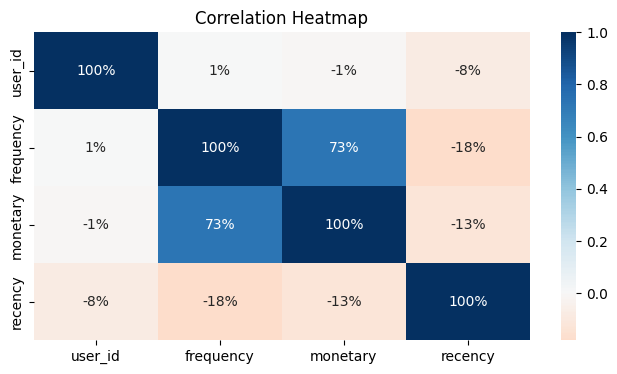

In [ ]:
customer_features['user_id'] = customer_features['user_id'].astype('str')

corr_matrix = customer_features.corr()
plt.figure(figsize=(8,4))  
sns.heatmap(corr_matrix
            , annot=True
            , cmap= 'RdBu'
            , center=0
            , fmt = '.0%')
plt.title('Correlation Heatmap')

In [ ]:
customer_features['R_score'] = pd.qcut(customer_features['recency'], q = 5, labels = [5,4,3,2,1], duplicates='drop')
customer_features['F_score'] = pd.qcut(customer_features['frequency'], q = 5, labels = [4,5], duplicates='drop')
customer_features['M_score'] = pd.qcut(customer_features['monetary'], q = 5, labels = [1,2,3,4,5], duplicates='drop')

In [ ]:
customer_features['R_score'] = customer_features['R_score'].astype(int)
customer_features['F_score'] = customer_features['F_score'].astype(int)
customer_features['M_score'] = customer_features['M_score'].astype(int)
customer_features['RFM_Score'] = customer_features['R_score'] * 100 + customer_features['F_score'] * 10 + customer_features['M_score']
customer_features

,user_id,frequency,monetary,recency,R_score,F_score,M_score,RFM_Segment,RFM_Score
0,138340325,1,93.50,20,2,4,2,Other,242
1,225644257,1,40.91,19,2,4,1,Other,241
2,253299396,1,246.85,25,1,4,3,Other,143
3,256164170,1,113.23,11,4,4,2,Other,442
4,267316896,1,189.71,17,2,4,3,Other,243
...,...,...,...,...,...,...,...,...,...
441633,579962677,1,1634.38,0,5,4,5,Other,545
441634,579963523,1,457.91,0,5,4,4,Other,544
441635,579964521,1,334.60,0,5,4,3,Other,543
441636,579966375,1,124.11,0,5,4,2,Other,542


In [ ]:
customer_features['RFM_Segment'] = 'Other'  # Default label for rows not matching any segment

# Champions
customer_features.loc[customer_features['RFM_Score'].isin([555, 554, 544, 545, 454, 455, 445]), 'RFM_Segment'] = 'Champions'

# Loyal
customer_features.loc[customer_features['RFM_Score'].isin([543, 444, 435, 355, 354, 345, 344, 335]), 'RFM_Segment'] = 'Loyal'

# Potential Loyalist
customer_features.loc[customer_features['RFM_Score'].isin([553, 551, 552, 541, 542, 533, 532, 531, 452, 451
                                                 , 442, 441, 431, 453, 433, 432, 423, 353, 352
                                                 , 351, 342, 341, 333, 323]), 'RFM_Segment'] = 'Potential Loyalist'

# Promising
customer_features.loc[customer_features['RFM_Score'].isin([525, 524, 523, 522, 521, 515, 514, 513
                                                 , 425, 424, 413, 414, 415, 315, 314, 313]), 'RFM_Segment'] = 'Promising'

# New Customers
customer_features.loc[customer_features['RFM_Score'].isin([512, 511, 422, 421, 412, 411, 311]), 'RFM_Segment'] = 'New Customers'

# Need Attention
customer_features.loc[customer_features['RFM_Score'].isin([535, 534, 443, 434, 343, 334, 325, 324]), 'RFM_Segment'] = 'Need Attention'

# About To Sleep
customer_features.loc[customer_features['RFM_Score'].isin([331, 321, 312, 221, 213, 231, 241, 251]), 'RFM_Segment'] = 'About To Sleep'

# At Risk
customer_features.loc[customer_features['RFM_Score'].isin([255, 254, 245, 244, 253, 252, 243, 242, 235
                                                 , 234, 225, 224, 153, 152, 145, 143, 142
                                                 , 135, 134, 133, 125, 124]), 'RFM_Segment'] = 'At Risk'

# Cannot Lose Them
customer_features.loc[customer_features['RFM_Score'].isin([155, 154, 144, 214, 215, 115, 114, 113]), 'RFM_Segment'] = 'Cannot Lose Them'

# Hibernating customers
customer_features.loc[customer_features['RFM_Score'].isin([332, 322, 233, 232, 223, 222, 132, 123, 122, 212, 211]), 'RFM_Segment'] = 'Hibernating customers'

# Lost customers
customer_features.loc[customer_features['RFM_Score'].isin([111, 112, 121, 131, 141, 151]), 'RFM_Segment'] = 'Lost customers'

# Display the DataFrame with the new RFM_Segment column
customer_features

,user_id,frequency,monetary,recency,R_score,F_score,M_score,RFM_Segment,RFM_Score
0,138340325,1,93.50,20,2,4,2,At Risk,242
1,225644257,1,40.91,19,2,4,1,About To Sleep,241
2,253299396,1,246.85,25,1,4,3,At Risk,143
3,256164170,1,113.23,11,4,4,2,Potential Loyalist,442
4,267316896,1,189.71,17,2,4,3,At Risk,243
...,...,...,...,...,...,...,...,...,...
441633,579962677,1,1634.38,0,5,4,5,Champions,545
441634,579963523,1,457.91,0,5,4,4,Champions,544
441635,579964521,1,334.60,0,5,4,3,Loyal,543
441636,579966375,1,124.11,0,5,4,2,Potential Loyalist,542


In [ ]:
treemap_input = customer_features.groupby(by = 'RFM_Segment',as_index=False).agg(count_cus = ('user_id','nunique')
                                                                            ,total_rev = ('monetary','sum'))
treemap_input

,RFM_Segment,count_cus,total_rev
0,About To Sleep,16726,7.529834e+05
1,At Risk,111600,5.902785e+07
2,Cannot Lose Them,18729,1.648202e+07
3,Champions,69872,1.304129e+08
4,Lost customers,23996,1.076093e+06
5,Loyal,63094,4.888711e+07
6,Need Attention,32648,8.124903e+06
7,Potential Loyalist,104973,1.043103e+07


In [ ]:
# Create a Treemap
fig = px.treemap(treemap_input, path=['RFM_Segment'], values='count_cus', title='RFM Segments - Customer Count Treemap')

# Show the plot
fig.show()

# Create a Treemap for total revenue
fig_rev = px.treemap(treemap_input, path=['RFM_Segment'], values='total_rev', title='RFM Segments - Total Revenue Treemap')

# Show the revenue plot
fig_rev.show()

In [ ]:
fig = make_subplots(rows=1, cols=2, subplot_titles=('Customer Count', 'Total Revenue'), specs=[[{'type':'domain'}, {'type':'domain'}]])

# Add pie charts to subplots
fig.add_trace(px.pie(treemap_input, names='RFM_Segment', values='count_cus').update_traces(textinfo='percent').data[0], 1, 1)
fig.add_trace(px.pie(treemap_input, names='RFM_Segment', values='total_rev').update_traces(textinfo='percent').data[0], 1, 2)

# Update layout
fig.update_layout(title='RFM Segments Analysis')

# Show the subplot
fig.show()

> BEST CUSTOMERS: 

1. The <b> Champions </b> group contains about 16% but contributed 47% Revenue. They must be reserved 🔥

2. The <b> Loyal + At risk </b> group is quite good so far, they contains 40% total customers, and brought nearly the same proportion in revenue contribution (roughly 1:1). They must also be nicely protected and rewarded ✔️